In [1]:
!pip install -U bitsandbytes

In [2]:
!pip install trl

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from warnings import filterwarnings

from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import SFTTrainer

import torch
from torch.utils.data import Dataset, DataLoader

import nltk
import re
import string

from datasets import Dataset, DatasetDict

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

# Preprocessing

In [4]:
data = pd.read_csv("/content/CombinedData.csv",index_col=0)

In [5]:
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
data["status"].value_counts()

,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


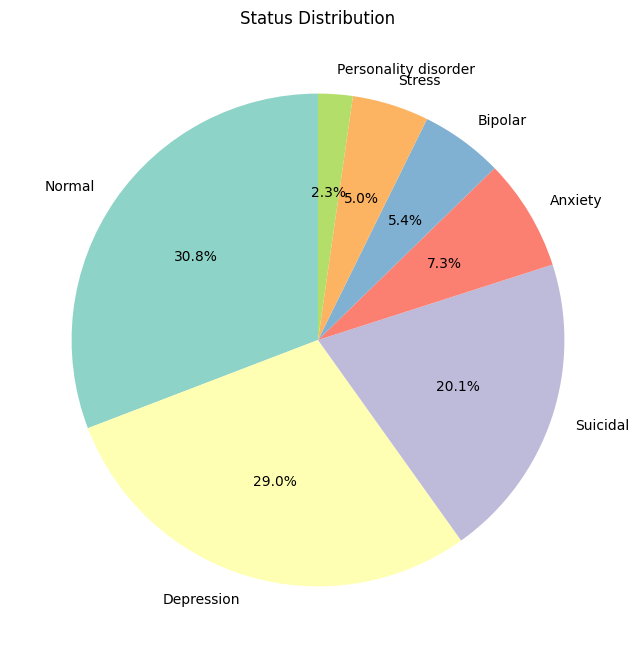

In [8]:
status_counts = data["status"].value_counts()

plt.figure(figsize=(8, 8))
status_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors,
    title="Status Distribution"
)
plt.ylabel("")
plt.show()

In [9]:
data.isna().sum()

,0
statement,362
status,0


In [10]:
data = data.dropna()

In [11]:
data.statement.duplicated(keep="first").value_counts()

,count
statement,
False,51073
True,1608


In [12]:
data = data.drop_duplicates(subset=['statement'], keep="first")

In [13]:
target_count = 5000

balanced_data = data.groupby("status").apply(
    lambda x: x.sample(min(len(x), target_count), random_state=42)
).reset_index(drop=True)

print("Original Class Distribution:")
print(data["status"].value_counts())

print("\nBalanced Class Distribution:")
print(balanced_data["status"].value_counts())

Original Class Distribution:
status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

Balanced Class Distribution:
status
Depression              5000
Suicidal                5000
Normal                  5000
Anxiety                 3617
Bipolar                 2501
Stress                  2293
Personality disorder     895
Name: count, dtype: int64


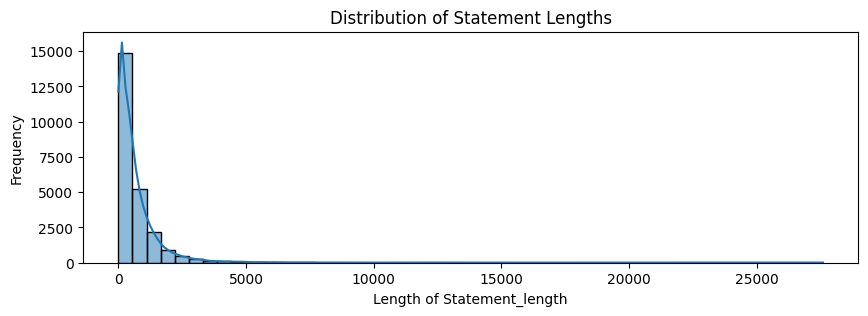

In [14]:
balanced_data['statement_length'] = balanced_data['statement'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(balanced_data['statement_length'], bins=50, kde=True)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Length of Statement_length')
plt.ylabel('Frequency')
plt.show()

In [15]:
balanced_data['words'] = [len(x.split()) for x in balanced_data['statement'].tolist()]

In [16]:
balanced_data[['words','statement']].head()

,words,statement
0,168,Fear of getting schizophrenia or any mental il...
1,201,My mind is tricking me into feeling like I nee...
2,178,Dont know whats wrong with me I really can't b...
3,78,A reminder that progress isn't linear and that...
4,185,Just had one of the worst anxiety attacks of m...


In [17]:
balanced_data['words'].describe()

,words
count,24306.00
mean,125.22
std,162.06
min,1.00
25%,23.00
50%,78.00
75%,164.00
max,5419.00


In [18]:
min_statement_size=16
balanced_data[balanced_data["words"] < min_statement_size].count()

,0
statement,4597
status,4597
statement_length,4597
words,4597


In [19]:
df = balanced_data[balanced_data['words'] > min_statement_size]

In [20]:
df['status'].value_counts()

,count
status,
Depression,4750
Suicidal,4633
Anxiety,3141
Bipolar,2480
Stress,2240
Normal,1407
Personality disorder,856


In [21]:
def preprocess_text(text):
    text = text.lower()  #Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['statement'] = df['statement'].apply(lambda x: preprocess_text(x))

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

df['statement'] = remove_stopwords(df['statement'])

In [24]:
rare_values = pd.Series(' '.join(df["statement"]).split()).value_counts()[-30:]
print(len(rare_values))
df["statement"] = df["statement"].apply(lambda x: " ".join(x for x in x.split() if x not in rare_values))

30


In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [27]:
df['statement'] = df['statement'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

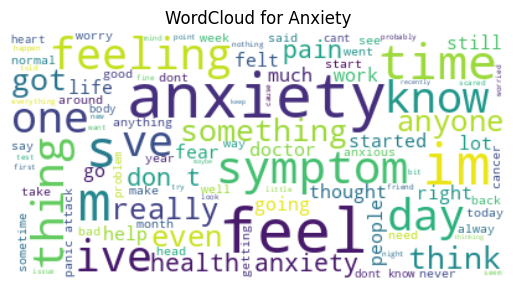

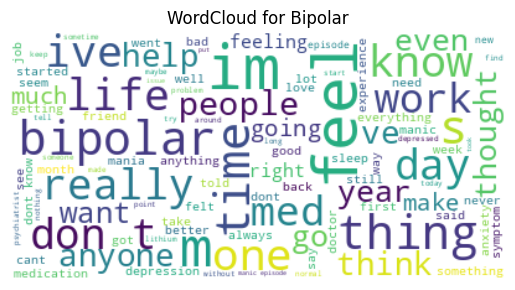

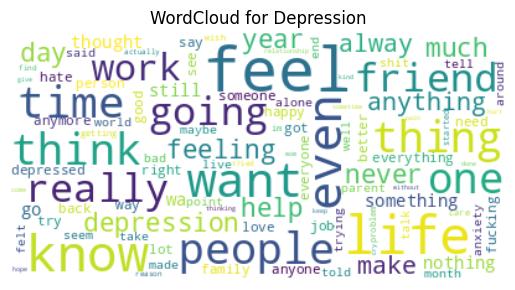

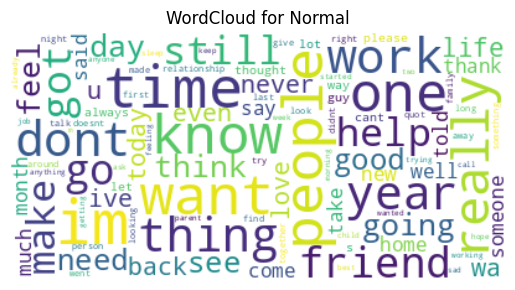

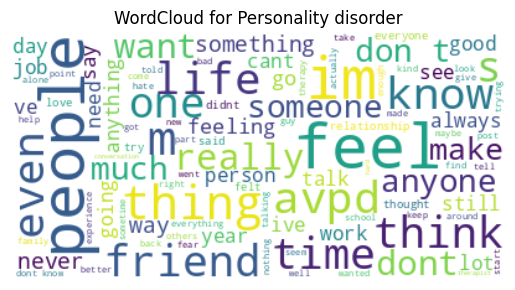

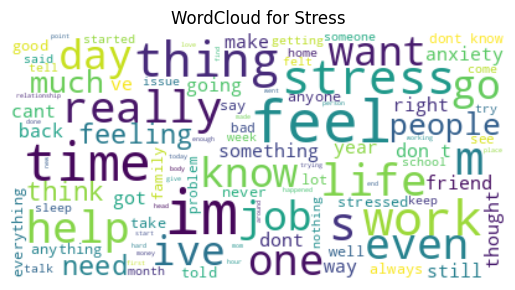

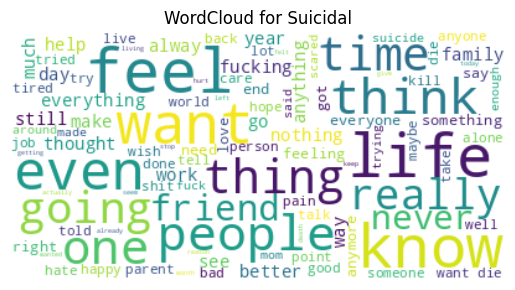

In [28]:
def generate_wordcloud(dataframe, text_column, group_column):

    groups = dataframe[group_column].unique()
    for group in groups:

        group_text = " ".join(dataframe[dataframe[group_column] == group][text_column].dropna())

        wordcloud = WordCloud(
            max_font_size=50,
            max_words=100,
            background_color="white"
        ).generate(group_text)

        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"WordCloud for {group}")
        plt.axis("off")
        plt.show()

generate_wordcloud(df, text_column="statement", group_column="status")

In [29]:
label_map = {
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
    'Anxiety': 3,
    'Bipolar': 4,
    'Stress': 5,
    'Personality disorder': 6
}
df["label"] = df["status"].map(label_map)

In [30]:
df.head()

,statement,status,statement_length,words,label
0,fear getting schizophrenia mental illness psyc...,Anxiety,872,168,3
1,mind tricking feeling like need urinate couple...,Anxiety,995,201,3
2,dont know whats wrong really cant believe anxi...,Anxiety,1027,178,3
3,reminder progress isnt linear thats okay felt ...,Anxiety,396,78,3
4,one worst anxiety attack life sleep still can’...,Anxiety,949,185,3


In [31]:
df = df.drop(["statement_length", "words"], axis=1)

In [32]:
df= df.sample(frac=1)

In [33]:
df.count()

,0
statement,19507
status,19507
label,19507


# BERT

In [34]:
train_x, test_x, train_y, test_y = train_test_split( df["statement"],
                                                     df["label"],
                                                     random_state=42)

In [35]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [36]:
train_encodings = bert_tokenizer(list(train_x), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = bert_tokenizer(list(test_x), truncation=True, padding=True, max_length=128, return_tensors="pt")

In [37]:
train_labels = torch.tensor(list(train_y))
test_labels = torch.tensor(list(test_y))

In [38]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [39]:
from transformers import AdamW

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)
bert_model.train()

optimizer = AdamW(bert_model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from torch.nn import CrossEntropyLoss
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
bert_model.to(device)

loss_fn = CrossEntropyLoss()

for epoch in range(15):
    bert_model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch + 1} tamamlandı, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1 tamamlandı, Loss: 0.8780, Accuracy: 0.6619
Epoch 2 tamamlandı, Loss: 0.5859, Accuracy: 0.7754
Epoch 3 tamamlandı, Loss: 0.4166, Accuracy: 0.8433
Epoch 4 tamamlandı, Loss: 0.2751, Accuracy: 0.9012
Epoch 5 tamamlandı, Loss: 0.1670, Accuracy: 0.9428
Epoch 6 tamamlandı, Loss: 0.1231, Accuracy: 0.9584
Epoch 7 tamamlandı, Loss: 0.0928, Accuracy: 0.9686
Epoch 8 tamamlandı, Loss: 0.0694, Accuracy: 0.9772
Epoch 9 tamamlandı, Loss: 0.0598, Accuracy: 0.9802
Epoch 10 tamamlandı, Loss: 0.0727, Accuracy: 0.9760
Epoch 11 tamamlandı, Loss: 0.0549, Accuracy: 0.9828
Epoch 12 tamamlandı, Loss: 0.0437, Accuracy: 0.9872
Epoch 13 tamamlandı, Loss: 0.0485, Accuracy: 0.9861
Epoch 14 tamamlandı, Loss: 0.0531, Accuracy: 0.9843
Epoch 15 tamamlandı, Loss: 0.0465, Accuracy: 0.9855


In [41]:
from sklearn.metrics import classification_report

bert_model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       349
           1       0.56      0.75      0.64      1150
           2       0.76      0.54      0.63      1180
           3       0.80      0.86      0.83       782
           4       0.86      0.77      0.81       609
           5       0.70      0.70      0.70       589
           6       0.79      0.57      0.66       218

    accuracy                           0.70      4877
   macro avg       0.74      0.70      0.71      4877
weighted avg       0.72      0.70      0.70      4877



In [42]:
text = "Controlling anxiety is not as easy as it sounds."

inputs = bert_tokenizer(
    text,
    max_length=128,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
)

In [43]:
bert_model.eval()

inputs = {key: val.to(device) for key, val in inputs.items()}

with torch.no_grad():
    outputs = bert_model(**inputs)
    logits = outputs.logits

predicted_class = torch.argmax(logits, dim=1).item()

print("Tahmin edilen sınıf:", predicted_class)

Tahmin edilen sınıf: 3


In [44]:
label_map_inverse = {v: k for k, v in label_map.items()}

predicted_label = label_map_inverse.get(predicted_class, "Unknown")
print("Tahmin edilen etiket:", predicted_label)

Tahmin edilen etiket: Anxiety


In [45]:
llama_input = f"Text: {text}\nPredicted Label: {predicted_label}\n\nSummarize the text based on its content and predicted label."
print("Llama Model Input:", llama_input)

Llama Model Input: Text: Controlling anxiety is not as easy as it sounds.
Predicted Label: Anxiety

Summarize the text based on its content and predicted label.


In [46]:
bert_model.save_pretrained("./mental_model")

In [47]:
bert_tokenizer.save_pretrained("./mental_model")

('./mental_model/tokenizer_config.json',
 './mental_model/special_tokens_map.json',
 './mental_model/vocab.txt',
 './mental_model/added_tokens.json')

# LLM

In [48]:
from huggingface_hub import login

login("######")

In [49]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)

In [50]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [51]:
inputs = tokenizer(llama_input, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        max_length=256,
        num_beams=5,
        early_stopping=True
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Llama Model Output:", generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Llama Model Output: Text: Controlling anxiety is not as easy as it sounds.
Predicted Label: Anxiety

Summarize the text based on its content and predicted label. The text discusses the challenges of controlling anxiety, suggesting that it is not as easy as it sounds. The predicted label is "Anxiety".

Here is a summary of the text based on its content and predicted label:

Anxiety is a complex and multifaceted issue that affects millions of people worldwide. Controlling anxiety is not as easy as it sounds, as it requires a deep understanding of the underlying causes of anxiety, as well as effective coping mechanisms and strategies. Anxiety can be debilitating and interfere with daily life, relationships, and overall well-being. Effective management of anxiety requires a comprehensive approach that addresses the physical, emotional, and psychological aspects of anxiety. This may involve seeking professional help, practicing stress-reducing techniques, and engaging in self-care activitie

In [52]:
#!pip install gradio

In [64]:
import gradio as gr

def classify_and_summarize(input_text):
    bert_inputs = bert_tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        bert_outputs = bert_model(**bert_inputs)
        logits = bert_outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        predicted_class = label_map_inverse.get(predicted_class, "Unknown")
        predicted_label = f"Class {predicted_class}"

    llama_input = f"Text: {input_text}\nPredicted Label: {predicted_label}\n\nSummarize the text based on its content and predicted label."
    llama_inputs = tokenizer(llama_input, return_tensors="pt").to("cpu")
    with torch.no_grad():
        llama_outputs = model.generate(
            input_ids=llama_inputs["input_ids"],
            max_length=256,
            num_beams=5,
            early_stopping=True
        )
    summary = tokenizer.decode(llama_outputs[0], skip_special_tokens=True)

    return f"Predicted Label: {predicted_label}\n\nSummary: {summary}"

with gr.Blocks() as demo:
    gr.Markdown("# Ruh Sağlığı Analizi ")
    gr.Markdown("Aşağıya şikayetinizi girin ve sınıflandırmak ve özet için düğmeye tıklayınız.")

    input_text = gr.Textbox(label="Enter your text here")

    classify_button = gr.Button("Classify and Summarize")

    output_text = gr.Textbox(label="Result")

    classify_button.click(
        fn=classify_and_summarize,
        inputs=[input_text],
        outputs=[output_text]
    )

demo.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://fc5de5ab466566e5d5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://fc5de5ab466566e5d5.gradio.live


# LLM-Fine Tuning

In [54]:
def format_data(row):
    return f"Input: {row['statement']}\nOutput: {row['status']}"

df["formatted_text"] = df.apply(format_data, axis=1)

dataset = Dataset.from_pandas(df)

In [55]:
dataset

Dataset({
    features: ['statement', 'status', 'label', 'formatted_text', '__index_level_0__'],
    num_rows: 19507
})

In [56]:
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [57]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['statement', 'status', 'label', 'formatted_text', '__index_level_0__'],
        num_rows: 15605
    })
    test: Dataset({
        features: ['statement', 'status', 'label', 'formatted_text', '__index_level_0__'],
        num_rows: 3902
    })
})

In [58]:
tokenizer.pad_token = tokenizer.eos_token

In [59]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [60]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

In [ ]:
def preprocess_function(examples):
    tokenized = tokenizer(examples["formatted_text"], truncation=True, padding="max_length", max_length=256)
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

processed_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["statement", "status", "formatted_text", "__index_level_0__"])

In [ ]:
def preprocess_function(examples):
    tokenized = tokenizer(
        examples["formatted_text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

processed_dataset = split_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["statement", "status", "formatted_text"]
)

In [63]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=300,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=500,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["test"],
    tokenizer=tokenizer
)

trainer.train()

NameError: name 'Trainer' is not defined

In [ ]:
model.save_pretrained("./finetuned_llama_lora")
tokenizer.save_pretrained("./finetuned_llama_lora")

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

predictions = trainer.predict(processed_dataset["test"])
decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(processed_dataset["test"]["labels"], skip_special_tokens=True)

reference_texts = [ref.split() for ref in decoded_labels]

bleu_score = sentence_bleu(reference_texts, decoded_preds)

print(f"BLEU Score: {bleu_score}")

In [ ]:
trainer.push_to_hub()